In [9]:
!pip install yfinance statsmodels pmdarima matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed


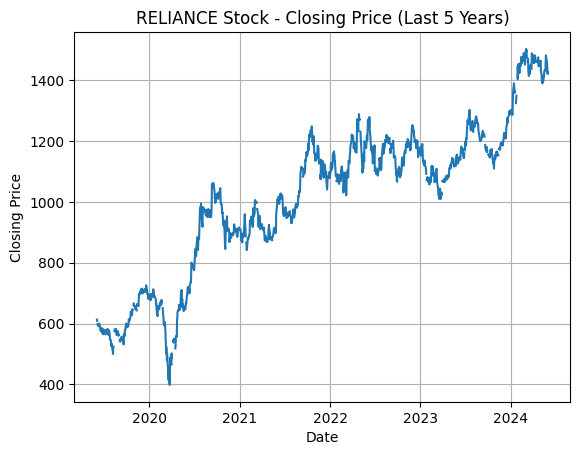

In [76]:
data = yf.download("RELIANCE.NS", start="2019-06-01", end="2024-06-01")['Close']
data.dropna(inplace=True)
data = data.asfreq('B')  # Set business day frequency'plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title("RELIANCE Stock - Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid()
plt.show()

In [77]:
result = adfuller(data.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("=> Data is stationary.")
else:
    print("=> Data is non-stationary.")


ADF Statistic: -1.157419668538803
p-value: 0.6916394322783649
Critical Values: {'1%': -3.4356819860439574, '5%': -2.863894574114006, '10%': -2.568023609111511}
=> Data is non-stationary.


In [78]:
d = 0
diff_data = data.copy()
while True:
    result = adfuller(diff_data.dropna())
    if result[1] < 0.05:
        break
    diff_data = diff_data.diff().dropna()
    d += 1

print(f"\nMade data stationary by differencing {d} time(s)")


Made data stationary by differencing 1 time(s)


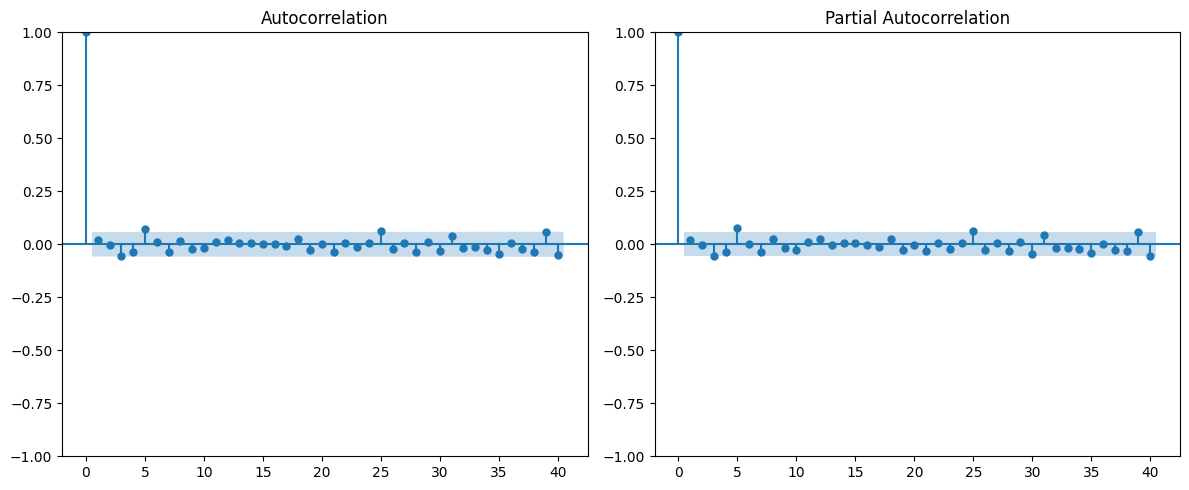

In [79]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

In [80]:
from statsmodels.tsa.arima.model import ARIMA

# Define p, d, q range
p = d = q = range(0, 4)  # You can increase upper limit if needed
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None
split = int(len(data) * 0.9)
train, test = data[:split], data[split:]
print("Trying combinations:")
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        print(f"ARIMA{order} AIC: {model_fit.aic}")
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except:
        continue

print("\nBest ARIMA order:", best_order)


Trying combinations:
ARIMA(0, 0, 0) AIC: 15168.602021745362
ARIMA(0, 0, 1) AIC: 13897.35029031655
ARIMA(0, 0, 2) AIC: 13284.383336496365
ARIMA(0, 0, 3) AIC: 12159.67236139541
ARIMA(0, 1, 0) AIC: 9383.236426770294
ARIMA(0, 1, 1) AIC: 9385.137082897647
ARIMA(0, 1, 2) AIC: 9387.123385961491
ARIMA(0, 1, 3) AIC: 9388.28438423681
ARIMA(0, 2, 0) AIC: 10162.406903572857
ARIMA(0, 2, 1) AIC: 9383.832855794451
ARIMA(0, 2, 2) AIC: 9385.74115778476
ARIMA(0, 2, 3) AIC: 9387.71892719685
ARIMA(0, 3, 0) AIC: 11435.944755751047
ARIMA(0, 3, 1) AIC: 10177.40387886102
ARIMA(0, 3, 2) AIC: 9410.608421703606
ARIMA(0, 3, 3) AIC: 9413.479501977927
ARIMA(1, 0, 0) AIC: 9400.022909319881
ARIMA(1, 0, 1) AIC: 9401.89327142144
ARIMA(1, 0, 2) AIC: 9403.865051602263
ARIMA(1, 0, 3) AIC: 9405.108167369852
ARIMA(1, 1, 0) AIC: 9385.136468698776
ARIMA(1, 1, 1) AIC: 9387.13533096639
ARIMA(1, 1, 2) AIC: 9389.081650379618
ARIMA(1, 1, 3) AIC: 9389.98759435141
ARIMA(1, 2, 0) AIC: 9839.89888932625
ARIMA(1, 2, 1) AIC: 9385.7304994

In [81]:
model = ARIMA(train, order = best_order)
model_fit = model.fit()
print(model_fit.summary())

arima_forecast = model_fit.forecast(steps=len(test))
arima_fitted_values = model_fit.fittedvalues
arima_forecast.index = test.index


                               SARIMAX Results                                
Dep. Variable:            RELIANCE.NS   No. Observations:                 1174
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -4684.575
Date:                Sat, 28 Jun 2025   AIC                           9381.150
Time:                        16:45:25   BIC                           9411.548
Sample:                    06-03-2019   HQIC                          9392.614
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5777      0.014    -40.568      0.000      -0.606      -0.550
ar.L2         -0.9602      0.015    -63.717      0.000      -0.990      -0.931
ma.L1         -0.4190      0.029    -14.290      0.0

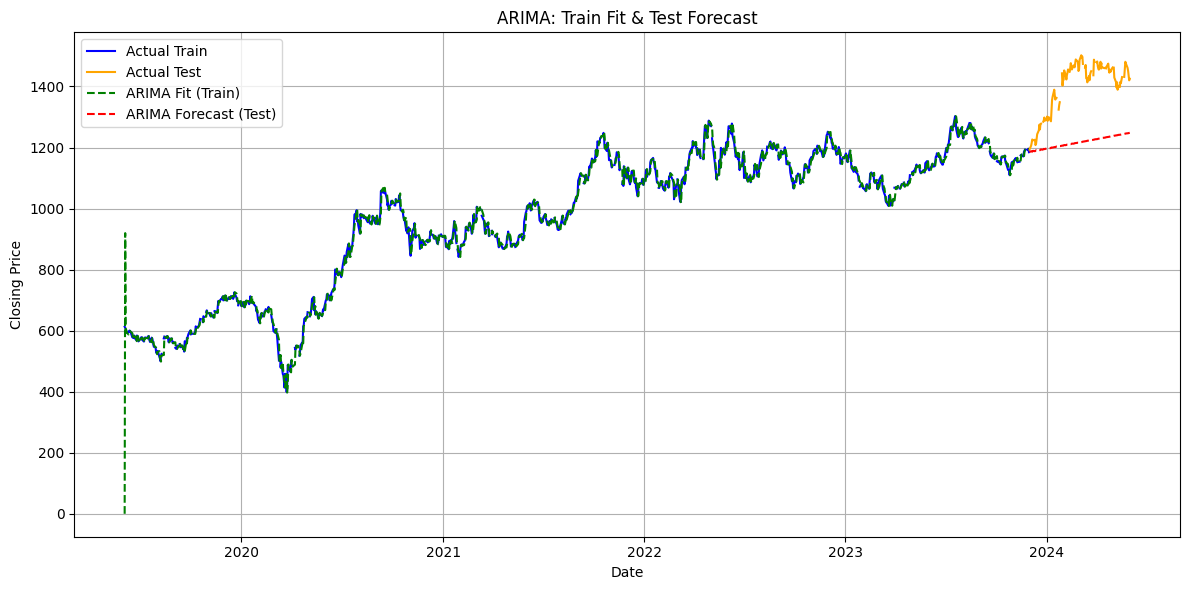

In [82]:
plt.figure(figsize=(12, 6))

# Plot actual train and test
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')

# Plot fitted values on train
plt.plot(arima_fitted_values, label="ARIMA Fit (Train)", color='green', linestyle='--')

# Plot forecast on test
plt.plot(arima_forecast, label="ARIMA Forecast (Test)", color='red', linestyle='--')

# Title and legends
plt.title("ARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
import numpy as np

# --- 1. Train RMSE for ARIMA ---

# Drop NaNs and align
arima_fitted_values_clean = arima_fitted_values.dropna()
train_aligned = train.loc[arima_fitted_values_clean.index].dropna()

# Ensure same index
common_index = arima_fitted_values_clean.index.intersection(train_aligned.index)

# Final aligned series
fitted_final = arima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Equal length (if needed)
min_len = min(len(fitted_final), len(train_final))
fitted_final = fitted_final[-min_len:]
train_final = train_final[-min_len:]

# Train RMSE
train_rmse_arima = np.sqrt(mean_squared_error(train_final, fitted_final))
print(f"ARIMA Train RMSE: {train_rmse_arima:.2f}")

# --- 2. Test RMSE for ARIMA ---

# Drop NaNs and align
arima_forecast_clean = arima_forecast.dropna()
test_clean = test.loc[arima_forecast_clean.index].dropna()

min_len_test = min(len(arima_forecast_clean), len(test_clean))
arima_forecast_final = arima_forecast_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]

# Test RMSE
test_rmse_arima = np.sqrt(mean_squared_error(test_final, arima_forecast_final))
print(f"ARIMA Test RMSE: {test_rmse_arima:.2f}")

ARIMA Train RMSE: 26.33
ARIMA Test RMSE: 193.70


In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional: Choose seasonal order manually
# (p,d,q) already chosen via grid search, or manually set
# You can tune these too
seasonal_order = (2, 2, 3, 5)  # (P,D,Q,s): s=5 for weekly seasonality on business days

# Fit SARIMA model on training data
sarima_model = SARIMAX(train,
                       order=best_order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())


                                     SARIMAX Results                                     
Dep. Variable:                       RELIANCE.NS   No. Observations:                 1174
Model:             SARIMAX(2, 2, 3)x(2, 2, 3, 5)   Log Likelihood               -4694.693
Date:                           Sat, 28 Jun 2025   AIC                           9411.387
Time:                                   16:45:50   BIC                           9466.843
Sample:                               06-03-2019   HQIC                          9432.327
                                    - 11-30-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3932      0.104    -13.343      0.000      -1.598      -1.189
ar.L2         -0.6861      0.112     -6.108

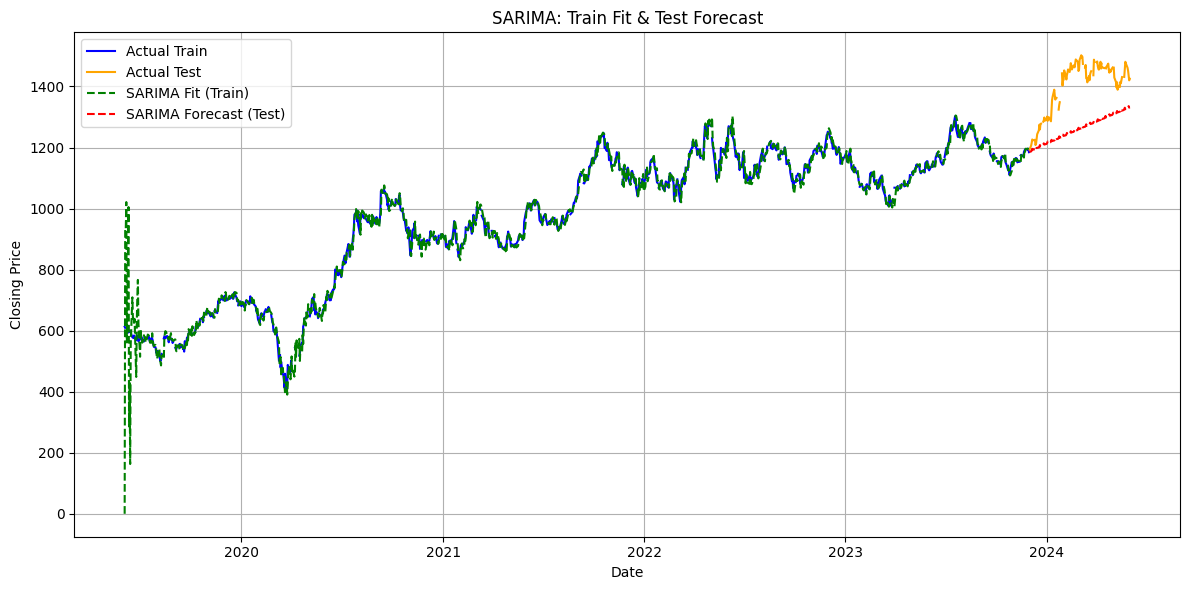

In [85]:
# Fitted values on train
sarima_fitted_values = sarima_result.fittedvalues

# Forecast on test
forecast_sarima = sarima_result.forecast(steps=len(test))
forecast_sarima.index = test.index  # Align with test set

# Plot everything
plt.figure(figsize=(12, 6))
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')
plt.plot(sarima_fitted_values, label="SARIMA Fit (Train)", color='green', linestyle='--')
plt.plot(forecast_sarima, label="SARIMA Forecast (Test)", color='red', linestyle='--')

plt.title("SARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop NaNs from both fitted and actual train data
sarima_fitted_values_clean = sarima_fitted_values.dropna()
train_aligned = train.loc[sarima_fitted_values_clean.index].dropna()

# Ensure matching index
common_index = sarima_fitted_values_clean.index.intersection(train_aligned.index)

# Filter both to matching dates only and drop NaNs again (final cleanup)
fitted_final = sarima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Final safeguard: ensure same length
min_len = min(len(train_final), len(fitted_final))
train_final = train_final[-min_len:]
fitted_final = fitted_final[-min_len:]

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(train_final, fitted_final))
print(f"SARIMA Train RMSE: {train_rmse:.2f}")

# --- 2. Test RMSE for SARIMA ---
forecast_sarima_clean = forecast_sarima.dropna()
test_clean = test.loc[forecast_sarima_clean.index].dropna()

# Align lengths just in case
min_len_test = min(len(forecast_sarima_clean), len(test_clean))
forecast_sarima_final = forecast_sarima_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]

test_rmse = np.sqrt(mean_squared_error(test_final, forecast_sarima_final))
print(f"SARIMA Test RMSE: {test_rmse:.2f}")


SARIMA Train RMSE: 38.27
SARIMA Test RMSE: 144.62
